<a name="1"></a>
## 1 - Importo Librerias

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import random
from sklearn.model_selection import train_test_split


%matplotlib inline

In [2]:
import string
import re
import nltk
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, twitter_samples, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 2 - Importo la Data

### 2.1 - Cargo los datos

In [4]:
data = pd.read_csv("sentiment_integrado.csv")
data.head(10)

,Unnamed: 0,id,texto,sentimiento,Cantidad palabras,cant caracteres especiales,cant menciones,cant hashtags
0,0,142389495503925248,"Salgo de #VeoTV , que día más largoooooo...",Indefinido,8,4,0,1
1,1,142389933619945473,@PauladeLasHeras No te libraras de ayudar me/n...,Neutral,10,2,1,0
2,2,142391947707940864,@marodriguezb Gracias MAR,Positivo,3,0,1,0
3,3,142416095012339712,"Off pensando en el regalito Sinde, la que se v...",Negativo,24,4,0,0
4,4,142422495721562112,Conozco a alguien q es adicto al drama! Ja ja ...,Positivo,15,2,0,0
5,5,142424715175280640,"RT @FabHddzC: Si amas a alguien, déjalo libre....",Indefinido,16,6,2,0
6,6,142483342040907776,Toca @crackoviadeTV3 . Grabación dl especial N...,Positivo,8,5,1,0
7,7,142493511634259968,Hoy asisitiré en Madrid a un seminario sobre l...,Indefinido,16,1,0,0
8,8,142494476051562496,Buen día todos! Lo primero mandar un abrazo gr...,Positivo,25,2,1,0
9,9,142496796416016384,Desde el escaño. Todo listo para empezar #endi...,Positivo,12,6,0,1


In [5]:
data = data.dropna(subset=['texto'])

In [6]:
data.value_counts("sentimiento")

sentimiento
Negativo      5798
Positivo      5680
Indefinido    3500
Neutral       2091
Name: count, dtype: int64

In [7]:
data['sentimiento'] = data['sentimiento'].replace('Indefinido', 'Neutral')

In [168]:
tf_count = data.value_counts("sentimiento")
tf_count

sentimiento
Negativo    5798
Positivo    5680
Neutral     5591
Name: count, dtype: int64

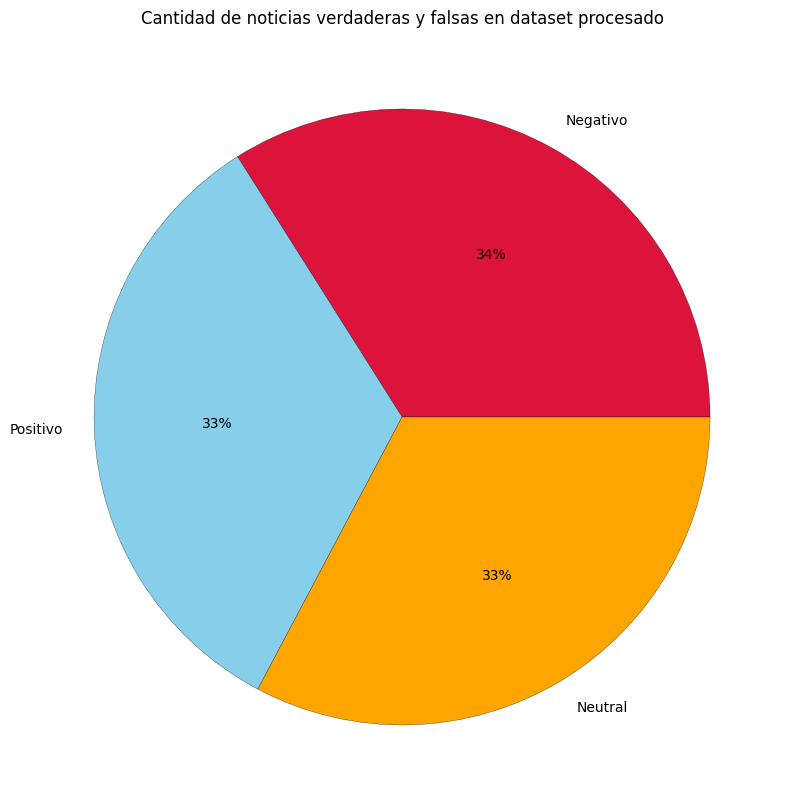

In [169]:
plt.figure(figsize=(10,10))
plt.pie(tf_count, labels=["Negativo", "Positivo","Neutral"],autopct="%1.f%%", colors=["crimson","skyblue", "orange"], wedgeprops={'linewidth': 0.2, 'edgecolor': 'black'})

plt.title("Cantidad de noticias verdaderas y falsas en dataset procesado")

plt.show()

### 2.2 - Procesamiento del Texto

In [170]:
stopwords_spanish = stopwords.words('spanish')
lemmatizer = WordNetLemmatizer()

In [171]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = nltk.pos_tag(tokenizer.tokenize(tweet))

    tweets_clean = []
    for word in tweet_tokens:
        if (word[0] not in stopwords_spanish and # remove stopwords
            word[0] not in string.punctuation): # remove punctuation
            stem_word = lemmatizer.lemmatize(word[0], pos_tag_convert(word[1]))
            tweets_clean.append(stem_word)
    return tweets_clean

In [172]:
def pos_tag_convert(nltk_tag: str) -> str:
    '''Converts nltk tags to tags that are understandable by the lemmatizer.

    Args:
        nltk_tag (str): nltk tag

    Returns:
        _ (str): converted tag
    '''
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [173]:
def load_tweets(data):
    tweets_positivos = data.loc[data['sentimiento'] == 'Positivo', 'texto'].tolist()
    tweets_negativos= data.loc[data['sentimiento'] == 'Negativo', 'texto'].tolist()
    tweets_neutrales = data.loc[data['sentimiento'] == 'Neutral', 'texto'].tolist()
    return tweets_positivos, tweets_negativos,tweets_neutrales

In [174]:
all_positive_tweets, all_negative_tweets,all_neutral_tweets = load_tweets(data)
print(f"The number of positive tweets: {len(all_positive_tweets)}")
print(f"The number of negative tweets: {len(all_negative_tweets)}")
print(f"The number of neutral tweets: {len(all_neutral_tweets)}")

The number of positive tweets: 5680
The number of negative tweets: 5798
The number of neutral tweets: 5591


Observamos algunos tweets de ejemplos

In [175]:
# Change the tweet number to any number between 0 and 4999 to see a different pair of tweets.
tweet_number = random.randint(0, len(all_neutral_tweets) - 1)
print('Positive tweet example:')
print(all_positive_tweets[tweet_number])
print('\nNegative tweet example:')
print(all_negative_tweets[tweet_number])
print('\nNeutral tweet example:')
print(all_neutral_tweets[tweet_number])

Positive tweet example:
Nos vemos en @TDtarde con @nievesherrero_ a partir de las 18:45 y con @susmoneo @JesusCintora @GOTZONEMORA Mari Pau y @lodares de invitado.

Negative tweet example:
Fuerte abrazo a @caraamable, que ha sufrido en sus carnes la acción de los piquetes 'informativos' por hacer su trabajo #mafia #intolerancia

Neutral tweet example:
Gobierno de Asturias en el aire. El órdago de Cascos se enfrenta ahora al escaño 17 logrado por el PSOE (voto emigrante)


In [176]:
# Process all the tweets: tokenize the string, remove tickers, handles, punctuation and stopwords, stem the words
all_positive_tweets_processed = [process_tweet(tweet) for tweet in all_positive_tweets]
all_negative_tweets_processed = [process_tweet(tweet) for tweet in all_negative_tweets]
all_neutral_tweets_processed = [process_tweet(tweet) for tweet in all_neutral_tweets]

Observamos a los tweets luego de ser procesados.

In [177]:
# Change the tweet number to any number between 0 and 4999 to see a different pair of tweets.
print('Positive tweet example:')
print(all_positive_tweets_processed[tweet_number])
print('\nNegative tweet example:')
print(all_negative_tweets_processed[tweet_number])
print('\nNeutral tweet example:')
print(all_neutral_tweets_processed[tweet_number])

Positive tweet example:
['vemos', 'partir', '18:45', 'mari', 'pau', 'invitado']

Negative tweet example:
['fuerte', 'abrazo', 'sufrido', 'carnes', 'acción', 'piquetes', 'informativos', 'hacer', 'trabajo', 'mafia', 'intolerancia']

Neutral tweet example:
['gobierno', 'asturias', 'aire', 'órdago', 'cascos', 'enfrenta', 'ahora', 'escaño', '17', 'logrado', 'psoe', 'voto', 'emigrante']


### 2.3 Divido Datos en Train, Test y Split

In [178]:
all_tweets = all_positive_tweets_processed + all_negative_tweets_processed + all_neutral_tweets_processed
labels = [2.0] * len(all_positive_tweets_processed) + [0.0] * len(all_negative_tweets_processed) + [1.0] * len(all_neutral_tweets_processed)

In [179]:
val_test_x, train_x, val_test_y, train_y = train_test_split(all_tweets, labels, test_size=0.8, random_state=42)
test_x, val_x, test_y, val_y = train_test_split(val_test_x, val_test_y, test_size=0.5, random_state=42)

print(f"There are {len(train_x)} sentences for training.")
print(f"There are {len(train_y)} labels for training.\n")
print(f"There are {len(val_x)} sentences for validation.")
print(f"There are {len(val_y)} labels for validation.")
print(f"There are {len(test_x)} sentences for test.")
print(f"There are {len(test_y)} labels for test.")

There are 13656 sentences for training.
There are 13656 labels for training.

There are 1707 sentences for validation.
There are 1707 labels for validation.
There are 1706 sentences for test.
There are 1706 labels for test.


In [180]:
print(train_x[5])
print(train_y[5])

['q', 'ma', 'preocupa', 'presupuestos', 'parecen', 'obedecer', 'unas', 'órdenes', 'mercados', 'rumbo', 'país', 'da']
0.0



### 2.2 - Construyo el Vocabulario

In [181]:
def build_vocabulary(corpus):
    '''Function that builds a vocabulary from the given corpus
    Input:
        - corpus (list): the corpus
    Output:
        - vocab (dict): Dictionary of all the words in the corpus.
                The keys are the words and the values are integers.
    '''

    # The vocabulary includes special tokens like padding token and token for unknown words
    # Keys are words and values are distinct integers (increasing by one from 0)
    vocab = {'': 0, '[UNK]': 1}

    i = 2
    for tweet in corpus:
        for word in tweet:
            if word not in vocab:
                vocab[word] = i
                i +=1


    return vocab

In [182]:
vocab = build_vocabulary(train_x)
num_words = len(vocab)

print(f"Vocabulary contains {num_words} words\n")
print(vocab)

Vocabulary contains 25996 words

{'': 0, '[UNK]': 1, 'ojala': 2, 'mañana': 3, 'vayan': 4, 'black': 5, 'friday': 6, 'toquen': 7, 'poquito': 8, 'corazón': 9, 'donen': 10, 'persona': 11, 'perdieron': 12, 'darth': 13, 'vader': 14, 'pudo': 15, 'muerte': 16, 'llevo': 17, 'triste': 18, 'sabee': 19, 'carrie': 20, 'fisher': 21, 'carriefisher': 22, 'soraya': 23, 'sáenz': 24, 'santamaría': 25, 'preside': 26, 'primera': 27, 'vez': 28, 'consejo': 29, 'ministros': 30, 'rajoy': 31, 'seguirá': 32, 'bruselas': 33, 'mhan': 34, 'comentat': 35, 'josep': 36, 'anglada': 37, 'està': 38, 'fent': 39, 'campanya': 40, 'igualada': 41, 'segurament': 42, 'vol': 43, 'anar': 44, 'rec': 45, '04': 46, 'i': 47, 'comprar': 48, 'abric': 49, 'ètnic': 50, '20n': 51, 'mmm': 52, 'quiero': 53, 'hacer': 54, 'spoiler': 55, 'hoy': 56, 'va': 57, 'ver': 58, 'nuevo': 59, 'canal': 60, 'podras': 61, 'video': 62, 'subire': 63, 'unas': 64, 'horas': 65, 'q': 66, 'ma': 67, 'preocupa': 68, 'presupuestos': 69, 'parecen': 70, 'obedecer': 71,

### 2.3 - Transformo Tweet a Tensor


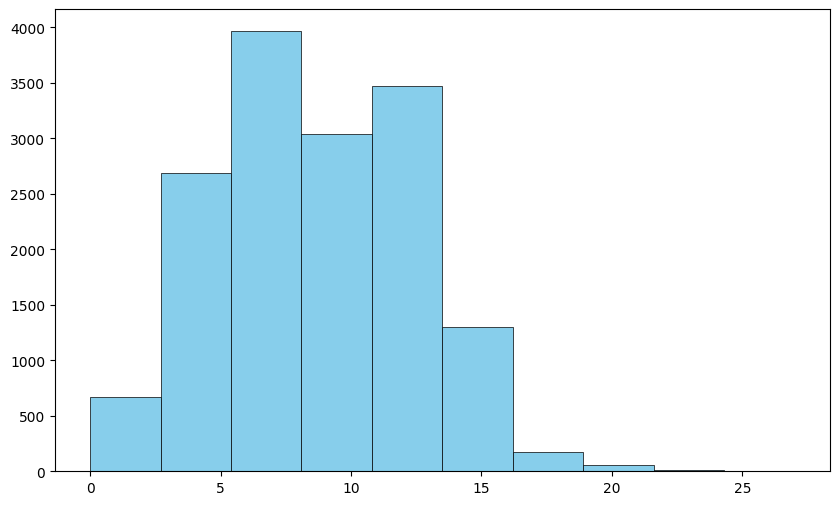

In [183]:
# Tweet lengths
plt.figure(figsize=(10,6))
plt.hist([len(t) for t in train_x + val_x],color="skyblue",linewidth=0.5,edgecolor='black');

In [184]:
def max_length(training_x, validation_x):
    """Computes the length of the longest tweet in the training and validation sets.

    Args:
        training_x (list): The tweets in the training set.
        validation_x (list): The tweets in the validation set.

    Returns:
        int: Length of the longest tweet.
    """
    max_len = 0
    corpus = training_x + validation_x
    for tweet in corpus:
        if len(tweet) > max_len:
            max_len = len(tweet)
    return max_len

In [185]:
max_len = max_length(train_x, val_x)
print(f'The length of the longest tweet is {max_len} tokens.')

The length of the longest tweet is 27 tokens.


In [186]:
def padded_sequence(tweet, vocab_dict, max_len, unk_token='[UNK]'):
    """transform sequences of words into padded sequences of numbers

    Args:
        tweet (list): A single tweet encoded as a list of strings.
        vocab_dict (dict): Vocabulary.
        max_len (int): Length of the longest tweet.
        unk_token (str, optional): Unknown token. Defaults to '[UNK]'.

    Returns:
        list: Padded tweet encoded as a list of int.
    """

    unk_ID = vocab_dict[unk_token]

    tensor = [vocab_dict.get(word,unk_ID) for word in tweet]

    padded_tensor = tensor + [ 0 for _ in range(max_len - len(tensor))]


    return padded_tensor

In [187]:
train_x_padded = [padded_sequence(x, vocab, max_len) for x in train_x]
val_x_padded = [padded_sequence(x, vocab, max_len) for x in val_x]
test_x_padded = [padded_sequence(x, vocab, max_len) for x in test_x]

### Dense Class

In [30]:
class Dense():
    """
    A dense (fully-connected) layer.
    """

    def __init__(self, n_units, input_shape, activation, stdev=0.1, random_seed=42):

        self.n_units = n_units
        self.random_generator = np.random.default_rng(seed=random_seed)
        self.activation = activation

        w = self.random_generator.normal(scale=stdev, size=(input_shape[1],self.n_units))

        self.weights = w


    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):

        dense = np.dot(x,self.weights)
        dense = self.activation(dense)

        return dense


### 3.4 - Modelo


In [188]:
from keras.metrics import Precision, Recall, F1Score
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import CategoricalAccuracy

In [189]:
# Multiclase
def create_model(num_words, embedding_dim, max_len):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        max_len (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=max_len),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(3, activation="softmax")
    ])


    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [190]:
# Create the model
model = create_model(num_words=num_words, embedding_dim=16, max_len=max_len)

print('The model is created!\n')

The model is created!



In [191]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 27, 16)            415936    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
 4 (GlobalAveragePooling1D)                                      
                                                                 
 dense_20 (Dense)            (None, 3)                 51        
                                                                 
Total params: 415987 (1.59 MB)
Trainable params: 415987 (1.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [192]:
# Prepare the data
train_x_prepared = np.array(train_x_padded)
val_x_prepared = np.array(val_x_padded)
test_x_prepared = np.array(test_x_padded)

train_y_prepared = np.array(train_y)
val_y_prepared = np.array(val_y)
test_y_prepared = np.array(test_y)


print('The data is prepared for training!\n')

The data is prepared for training!



In [193]:
# Fit the model
print('Training:')
history = model.fit(train_x_prepared, train_y_prepared, epochs=20, validation_data=(val_x_prepared, val_y_prepared))

Training:
Epoch 1/20
427/427 [==============================] - 4s 7ms/step - loss: 1.0924 - accuracy: 0.4289 - val_loss: 1.0825 - val_accuracy: 0.4411
Epoch 2/20
427/427 [==============================] - 3s 7ms/step - loss: 1.0413 - accuracy: 0.6033 - val_loss: 1.0292 - val_accuracy: 0.5524
Epoch 3/20
427/427 [==============================] - 4s 9ms/step - loss: 0.9391 - accuracy: 0.6905 - val_loss: 0.9708 - val_accuracy: 0.5653
Epoch 4/20
427/427 [==============================] - 3s 8ms/step - loss: 0.8271 - accuracy: 0.7389 - val_loss: 0.9357 - val_accuracy: 0.5723
Epoch 5/20
427/427 [==============================] - 3s 7ms/step - loss: 0.7258 - accuracy: 0.7784 - val_loss: 0.9181 - val_accuracy: 0.5753
Epoch 6/20
427/427 [==============================] - 3s 7ms/step - loss: 0.6367 - accuracy: 0.8150 - val_loss: 0.9091 - val_accuracy: 0.5776
Epoch 7/20
427/427 [==============================] - 4s 9ms/step - loss: 0.5593 - accuracy: 0.8445 - val_loss: 0.9102 - val_accuracy: 0.5


## 4 - Evaluacion del modelo

In [194]:
results = model.evaluate(test_x_prepared, test_y_prepared)

54/54 [==============================] - 0s 2ms/step - loss: 1.2737 - accuracy: 0.5328


In [195]:
# Imprimir los resultados
print("Loss:", results[0])
print("Accuracy:", results[1])

Loss: 1.2737287282943726
Accuracy: 0.5328253507614136


In [196]:
predictions = model.predict(test_x_prepared)


54/54 [==============================] - 0s 2ms/step


In [197]:
pred_y = np.argmax(predictions, axis=1)

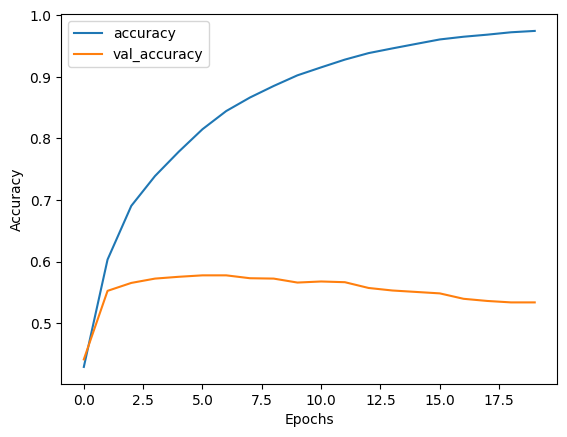

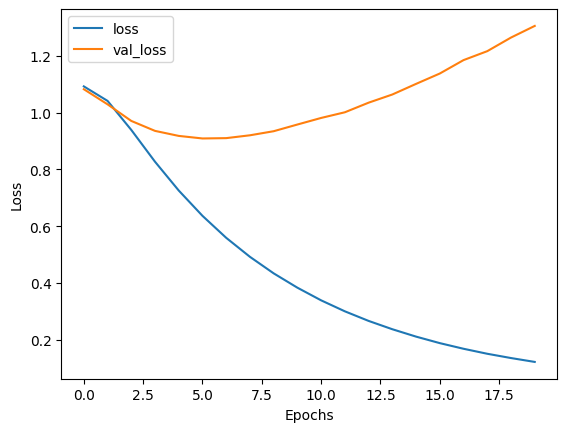

In [198]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [199]:
from sklearn.metrics import classification_report

print(classification_report(test_y_prepared,pred_y))

              precision    recall  f1-score   support

         0.0       0.56      0.56      0.56       576
         1.0       0.44      0.41      0.43       563
         2.0       0.59      0.63      0.61       567

    accuracy                           0.53      1706
   macro avg       0.53      0.53      0.53      1706
weighted avg       0.53      0.53      0.53      1706



In [200]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y_prepared,pred_y)

array([[322, 161,  93],
       [178, 231, 154],
       [ 80, 131, 356]])

In [ ]:
# Prepare an example with 10 positive and 10 negative tweets.
example_for_prediction = np.append(val_x_prepared[0:10], val_x_prepared[-10:], axis=0)

# Make a prediction on the tweets.
model.predict(example_for_prediction)

1/1 [==============================] - 0s 63ms/step


array([[0.8979344 ],
       [0.9943414 ],
       [0.9969025 ],
       [0.9523676 ],
       [0.9976593 ],
       [0.9961576 ],
       [0.9922442 ],
       [0.97965586],
       [0.9984296 ],
       [0.9983224 ],
       [0.01059858],
       [0.04203636],
       [0.01296458],
       [0.01649778],
       [0.01767312],
       [0.00630509],
       [0.01558536],
       [0.00818982],
       [0.02310208],
       [0.03217777]], dtype=float32)